In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import keras
from keras import optimizers
from keras.losses import categorical_crossentropy as logloss
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

from xception import Xception, preprocess_input

In [3]:
data_dir = "/home/atik/Documents/Summer_1/data/"

In [4]:
data_generator = ImageDataGenerator(
    rotation_range=30, 
    zoom_range=0.3,
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.001,
    channel_shift_range=0.1,
    fill_mode='reflect',
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

data_generator_val = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

train_generator = data_generator.flow_from_directory(
    data_dir + "/train/",
    target_size=(299, 299),
    batch_size=64, shuffle=False
)

val_generator = data_generator_val.flow_from_directory(
    data_dir +"/val/",
    target_size=(299, 299),
    batch_size=64, shuffle=False
)

Found 25600 images belonging to 256 classes.
Found 5120 images belonging to 256 classes.


# Model

In [5]:
model = Xception(weight_decay=1e-5)
model.count_params()

2022-05-27 12:43:18.653688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 12:43:18.671091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 12:43:18.671413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 12:43:18.672204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

21386024

# Training

In [6]:
# add entropy to the usual logloss (it is for regularization),
# "Regularizing Neural Networks by Penalizing Confident Output Distributions",
# https://arxiv.org/abs/1701.06548
# it reduces overfitting a little bit
def loss(y_true, y_pred):
    entropy = -K.mean(K.sum(y_pred*K.log(y_pred), 1))
    beta = 0.1
    return logloss(y_true, y_pred) - beta*entropy

In [7]:
model.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), 
    loss=loss, metrics=['categorical_crossentropy', 'accuracy', 'top_k_categorical_accuracy']
)

In [19]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=266, epochs=30, verbose=1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, epsilon=0.007),
        EarlyStopping(monitor='val_acc', patience=4, min_delta=0.01)
    ],
    validation_data=val_generator, validation_steps=80, workers=4
)

/tmp/ipykernel_2747/3415227576.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/30
266/266 [==============================] - 67s 248ms/step - loss: 2.7093 - categorical_crossentropy: 3.0844 - accuracy: 0.4824 - top_k_categorical_accuracy: 0.6818 - val_loss: 1.0808 - val_categorical_crossentropy: 1.2601 - val_accuracy: 0.7711 - val_top_k_categorical_accuracy: 0.9318 - lr: 1.0000e-05
Epoch 2/30
266/266 [==============================] - 67s 251ms/step - loss: 2.6787 - categorical_crossentropy: 3.0529 - accuracy: 0.4867 - top_k_categorical_accuracy: 0.6937 - val_loss: 1.0925 - val_categorical_crossentropy: 1.2763 - val_accuracy: 0.7713 - val_top_k_categorical_accuracy: 0.9326 - lr: 1.0000e-05
Epoch 3/30
266/266 [==============================] - 69s 257ms/step - loss: 2.6955 - categorical_crossentropy: 3.0704 - accuracy: 0.4842 - top_k_categorical_accuracy: 0.6857 - val_loss: 1.1167 - val_categorical_crossentropy: 1.3087 - val_accuracy: 0.7723 - val_top_k_categorical_accuracy: 0.9316 - lr: 1.0000e-05
Epoch 4/30
266/266 [==============================] - 69s 

266/266 [==============================] - 69s 255ms/step - loss: 2.6613 - categorical_crossentropy: 3.0323 - accuracy: 0.4840 - top_k_categorical_accuracy: 0.6955 - val_loss: 1.0905 - val_categorical_crossentropy: 1.2737 - val_accuracy: 0.7721 - val_top_k_categorical_accuracy: 0.9314 - lr: 1.0000e-05
Epoch 10/30
266/266 [==============================] - 69s 257ms/step - loss: 2.6954 - categorical_crossentropy: 3.0683 - accuracy: 0.4821 - top_k_categorical_accuracy: 0.6819 - val_loss: 1.0918 - val_categorical_crossentropy: 1.2754 - val_accuracy: 0.7717 - val_top_k_categorical_accuracy: 0.9320 - lr: 1.0000e-05
Epoch 11/30
266/266 [==============================] - 70s 261ms/step - loss: 2.6762 - categorical_crossentropy: 3.0485 - accuracy: 0.4820 - top_k_categorical_accuracy: 0.6894 - val_loss: 1.0942 - val_categorical_crossentropy: 1.2787 - val_accuracy: 0.7730 - val_top_k_categorical_accuracy: 0.9312 - lr: 1.0000e-05
Epoch 12/30
266/266 [==============================] - 69s 256ms/st

266/266 [==============================] - 70s 260ms/step - loss: 2.7175 - categorical_crossentropy: 3.0927 - accuracy: 0.4824 - top_k_categorical_accuracy: 0.6823 - val_loss: 1.0936 - val_categorical_crossentropy: 1.2782 - val_accuracy: 0.7719 - val_top_k_categorical_accuracy: 0.9314 - lr: 1.0000e-05
Epoch 18/30
266/266 [==============================] - 70s 260ms/step - loss: 2.6490 - categorical_crossentropy: 3.0193 - accuracy: 0.4979 - top_k_categorical_accuracy: 0.6911 - val_loss: 1.0909 - val_categorical_crossentropy: 1.2741 - val_accuracy: 0.7711 - val_top_k_categorical_accuracy: 0.9316 - lr: 1.0000e-05
Epoch 19/30
266/266 [==============================] - 69s 257ms/step - loss: 2.7505 - categorical_crossentropy: 3.1263 - accuracy: 0.4714 - top_k_categorical_accuracy: 0.6737 - val_loss: 1.0768 - val_categorical_crossentropy: 1.2549 - val_accuracy: 0.7699 - val_top_k_categorical_accuracy: 0.9320 - lr: 1.0000e-05
Epoch 20/30
266/266 [==============================] - 70s 259ms/st

266/266 [==============================] - 69s 259ms/step - loss: 2.6666 - categorical_crossentropy: 3.0386 - accuracy: 0.4910 - top_k_categorical_accuracy: 0.6924 - val_loss: 1.0891 - val_categorical_crossentropy: 1.2723 - val_accuracy: 0.7719 - val_top_k_categorical_accuracy: 0.9326 - lr: 1.0000e-05
Epoch 26/30
266/266 [==============================] - 70s 260ms/step - loss: 2.6308 - categorical_crossentropy: 3.0013 - accuracy: 0.4998 - top_k_categorical_accuracy: 0.7021 - val_loss: 1.1065 - val_categorical_crossentropy: 1.2958 - val_accuracy: 0.7709 - val_top_k_categorical_accuracy: 0.9320 - lr: 1.0000e-05
Epoch 27/30
266/266 [==============================] - 69s 258ms/step - loss: 2.7234 - categorical_crossentropy: 3.1003 - accuracy: 0.4758 - top_k_categorical_accuracy: 0.6842 - val_loss: 1.0997 - val_categorical_crossentropy: 1.2869 - val_accuracy: 0.7725 - val_top_k_categorical_accuracy: 0.9318 - lr: 1.0000e-05
Epoch 28/30
266/266 [==============================] - 70s 259ms/st

# Loss/epoch plots

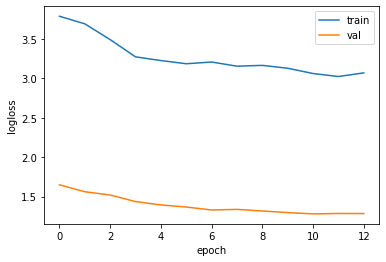

In [10]:
plt.plot(model.history.history['categorical_crossentropy'], label='train');
plt.plot(model.history.history['val_categorical_crossentropy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');

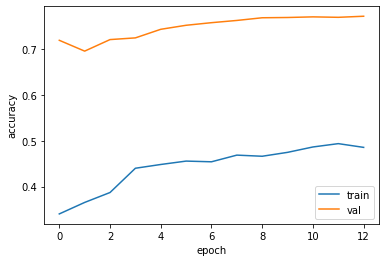

In [13]:
plt.plot(model.history.history['acc'], label='train');
plt.plot(model.history.history['val_acc'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

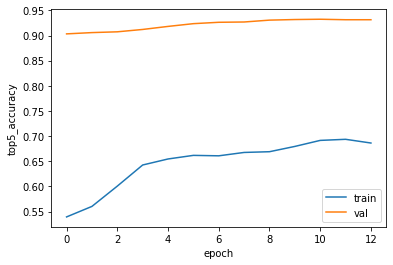

In [14]:
plt.plot(model.history.history['top_k_categorical_accuracy'], label='train');
plt.plot(model.history.history['val_top_k_categorical_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Results

In [18]:
model.evaluate_generator(val_generator, 80)

/tmp/ipykernel_2747/4197566343.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_generator, 80)


[1.0985087156295776, 1.2842930555343628, 0.7720702886581421, 0.931445300579071]

In [21]:
model.save_weights('xception_weights.hdf5')